---

## **Mathematical Formulation**

### **Decision Variables**
Let:
- $ X_{ij} \in \mathbb{Z}^+ $ : Number of units shipped by land from city $ i $ to city $ j $.
- $ Y_j \in \mathbb{Z}^+ $ : Number of units shipped by sea arriving at city $ j $.
- $ p_i \in \mathbb{Z}^+ $ : Production units at city $ i $.
- $ z_i \in \{0,1\} $ : Binary variable indicating if city $ i $ is producing.
- $ e^S_j, e^L_j \in \{0,1\} $ : Binary variable for extra small ($ e^S $) and large ($ e^L $) containers at city $ j $.
- $ \alpha_j, \beta_j \in \mathbb{Z}^+ $ : The number of large and small containers at city $ j $.
- $ d_j, r_j \in \mathbb{Z}^+ $ : Difference and remainder variables for container constraints.

### Constants
- **Demand vector:** $ \mathbf{D} $  
- **Manufacturing cost vector:** $ \mathbf{m} $ (per city), with $ m_0 $ representing sea-based manufacturing costs  
- **Shipping cost vector:** $ \mathbf{S} $  
  - $ S^S $ for small containers  
  - $ S^L $ for large containers  
  - $ S^D $ for LCL (less-than-container-load) shipping  
- **Lead time vector:** $ \mathbf{L} $  
- **Land cost matrix:** $ \mathbf{R} $  

### **Objective Function**
Minimize total costs:
$$
\begin{align}
\min \quad & \sum_{i,j} R_{ij} X_{ij} 
+ \sum_{i} \Big[ S^L_i (\alpha_i + e^L_i) + S^S_i (\beta_i + e^S_i) + S^D_i d_i \Big] + \sum_{i} \Big[ 500 z_i m_i + Y_i m_0 \Big] 
+ \sum_{i} \Big[ 0.15*L_i*m_0[(\alpha_i + e^L_i)*200+ (\beta_i + e^S_i)*100] \Big]
\end{align}
$$

### **Constraints**

#### **Demand Constraints:**
$$
(500  z_i + \sum_{i \neq j} X_{ij} + Y_j)-\sum_{i \neq j} X_{ji}  \geq D_j, \quad \forall j
$$

#### **Production Constraints:**

$$
\sum_{i} z_i \le 1
$$

#### **Shipping Size Logic:**
$$
Y_i = 200 \alpha_i + 100 \beta_i + r_i, \quad \forall i
$$
$$
e^S_i + e^L_i \leq 1, \quad \forall i
$$
$$
d_i + r_i \ge 200 e^L_i, \quad \forall i
$$
$$
d_i + r_i \ge 100 e^S_i, \quad \forall i
$$

$$
x,y,z,\alpha,\beta,d,r,e \ge 0
$$

---


In [31]:
# Demand vector (D)
D = {
    "Adelaide": 420,
    "Brisbane": 870,
    "Melbourne": 1250,
    "Perth": 930,
    "Sydney": 1310
}

# Manufacturing cost vector (m), with m_0 for sea delivery
m = {
    "Adelaide": 450,
    "Brisbane": 480,
    "Melbourne": 505,
    "Perth": 490,
    "Sydney": 515,
    "Ovis": 440  # Sea-delivered
}

# Shipping cost vector (S)
S_L = {  # Large Containers (40')
    "Adelaide": 2000,
    "Brisbane": 1600,
    "Melbourne": 1800,
    "Perth": 1200,
    "Sydney": 1650
}

S_S = {  # Small Containers (20')
    "Adelaide": 1200,
    "Brisbane": 1000,
    "Melbourne": 1100,
    "Perth": 700,
    "Sydney": 1050
}

S_Delta = {  # LCL Unit Shipping
    "Adelaide": 25,
    "Brisbane": 20,
    "Melbourne": 23,
    "Perth": 15,
    "Sydney": 22
}

# Lead Time vector (L)
L = {
    "Adelaide": 30,
    "Brisbane": 21,
    "Melbourne": 28,
    "Perth": 18,
    "Sydney": 25
}

# Land Cost Matrix (R)
R = {
    "Adelaide":     {"Adelaide": 0,  "Brisbane": 35, "Melbourne": 10, "Perth": 35, "Sydney": 25},
    "Brisbane":     {"Adelaide": 35, "Brisbane": 0,  "Melbourne": 25, "Perth": 70, "Sydney": 15},
    "Melbourne":    {"Adelaide": 10, "Brisbane": 25, "Melbourne": 0,  "Perth": 45, "Sydney": 15},
    "Perth":        {"Adelaide": 35, "Brisbane": 70, "Melbourne": 45, "Perth": 0,  "Sydney": 55},
    "Sydney":       {"Adelaide": 25, "Brisbane": 15, "Melbourne": 15, "Perth": 55, "Sydney": 0}
}

In [32]:
from gurobipy import Model, GRB

# Define cities
cities = ["Adelaide", "Brisbane", "Melbourne", "Perth", "Sydney"]

# Initialize Gurobi Model
model = Model("Shipping_Optimization")

# Decision Variables
X = model.addVars(cities, cities, vtype=GRB.INTEGER, name="X")  # Land shipping
Y = model.addVars(cities, vtype=GRB.INTEGER, name="Y")  # Sea shipping
z = model.addVars(cities, vtype=GRB.BINARY, name="z")  # Production indicator

eS = model.addVars(cities, vtype=GRB.BINARY, name="eS")  # Small extra container indicator
eL = model.addVars(cities, vtype=GRB.BINARY, name="eL")  # Large extra container indicator

alpha = model.addVars(cities, vtype=GRB.INTEGER, name="alpha")  # Large container count
beta = model.addVars(cities, vtype=GRB.INTEGER, name="beta")  # Small container count

d = model.addVars(cities, vtype=GRB.INTEGER, name="d")  # Difference variable
r = model.addVars(cities, vtype=GRB.INTEGER, name="r")  # Remainder variable

# Constraint: X_ij when i = j is always 0
for city in cities:
    model.addConstr(X[city, city] == 0, name=f"NoSelfShipping_{city}")

# Objective Function: Minimize total cost
model.setObjective(
    sum(R[i][j] * X[i, j] for i in cities for j in cities) + # Land Shipping Cost
    sum(S_L[i] * (alpha[i] + eL[i]) + S_S[i] * (beta[i] + eS[i]) + S_Delta[i] * d[i] for i in cities) + # Sea Shipping
    sum(500 * z[i] * m[i] + Y[i] * m["Ovis"] for i in cities) + # Manufacturing Cost
    sum(0.15 * L[i] * m["Ovis"] * ((alpha[i] + eL[i]) * 200 + (beta[i] + eS[i]) * 100) for i in cities), # Holding Cost
    GRB.MINIMIZE
)

# Demand Constraints
for j in cities:
    model.addConstr(
        (500 * z[j] + sum(X[i, j] for i in cities if i != j) + Y[j]) - sum(X[j, k] for k in cities if k != j) >= D[j],
        name=f"Demand_{j}"
    )

# Production Constraint: Only one city can be producing
model.addConstr(sum(z[i] for i in cities) <= 1, name="Production_Limit")

# Shipping Size Logic
for i in cities:
    model.addConstr(Y[i] == 200 * alpha[i] + 100 * beta[i] + r[i], name=f"Container_Size_{i}")
    model.addConstr(eS[i] + eL[i] <= 1, name=f"Container_Type_{i}") # Only one container type can be used - OPTIONAL
    model.addConstr(d[i] + r[i] == 200 * eL[i]+100 * eS[i], name=f"Container_Min_{i}")


# Non-negativity Constraints
for var in [X, Y, alpha, beta, d, r]:
    for key in var:
        model.addConstr(var[key] >= 0, name=f"NonNegative_{key}")

# Optimize Model
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 76 rows, 65 columns and 160 nonzeros
Model fingerprint: 0x0f4cfa5d
Variable types: 0 continuous, 65 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1.093925e+07
Presolve removed 55 rows and 10 columns
Presolve time: 0.00s
Presolved: 21 rows, 55 columns, 100 nonzeros
Variable types: 0 continuous, 55 integer (15 binary)

Root relaxation: objective 7.402420e+06, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7402420.00    0    1 1.0939e+07 7402420.00  32.3

In [33]:
# Print Results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    print(f"Total Cost: {model.objVal}")
    
    # Collect results
    X_values = {i: {j: X[i, j].x for j in cities} for i in cities}
    Y_values = {i: Y[i].x for i in cities}
    z_values = {i: z[i].x for i in cities}
    eS_values = {i: eS[i].x for i in cities}
    eL_values = {i: eL[i].x for i in cities}
    alpha_values = {i: alpha[i].x for i in cities}
    beta_values = {i: beta[i].x for i in cities}
    d_values = {i: d[i].x for i in cities}
    r_values = {i: r[i].x for i in cities}

    # Print results
    print("X values (Land shipping):", X_values)
    print("Y values (Sea shipping):", Y_values)
    print("z values (Production indicator):", z_values)
    print("eS values (Small extra container indicator):", eS_values)
    print("eL values (Large extra container indicator):", eL_values)
    print("alpha values (Large container count):", alpha_values)
    print("beta values (Small container count):", beta_values)
    print("d values (Difference variable):", d_values)
    print("r values (Remainder variable):", r_values)

else:
    print("No optimal solution found.")


Optimal solution found:
Total Cost: 7426699.999999999
X values (Land shipping): {'Adelaide': {'Adelaide': 0.0, 'Brisbane': 370.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}, 'Brisbane': {'Adelaide': -0.0, 'Brisbane': 0.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}, 'Melbourne': {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': 0.0, 'Perth': -0.0, 'Sydney': -0.0}, 'Perth': {'Adelaide': 790.0, 'Brisbane': -0.0, 'Melbourne': 1250.0, 'Perth': 0.0, 'Sydney': 1310.0}, 'Sydney': {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': 0.0}}
Y values (Sea shipping): {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': -0.0, 'Perth': 4280.0, 'Sydney': -0.0}
z values (Production indicator): {'Adelaide': -0.0, 'Brisbane': 1.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}
eS values (Small extra container indicator): {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}
eL values (Large extra container indicator): {'Adelaide':

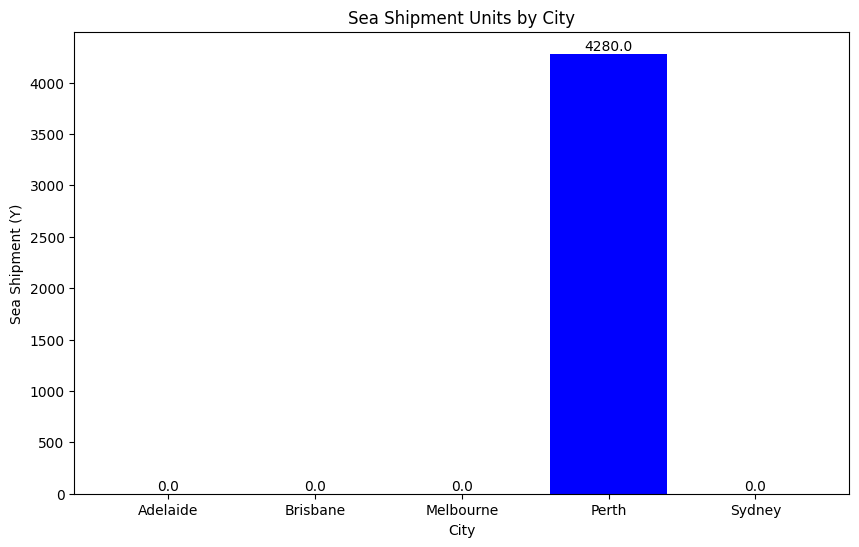

In [44]:
import matplotlib.pyplot as plt

# Plot the sea shipment values
plt.figure(figsize=(10, 6))
bars = plt.bar(Y_values.keys(), Y_values.values(), color='blue')
plt.xlabel('City')
plt.ylabel('Sea Shipment (Y)')
plt.title('Sea Shipment Units by City')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

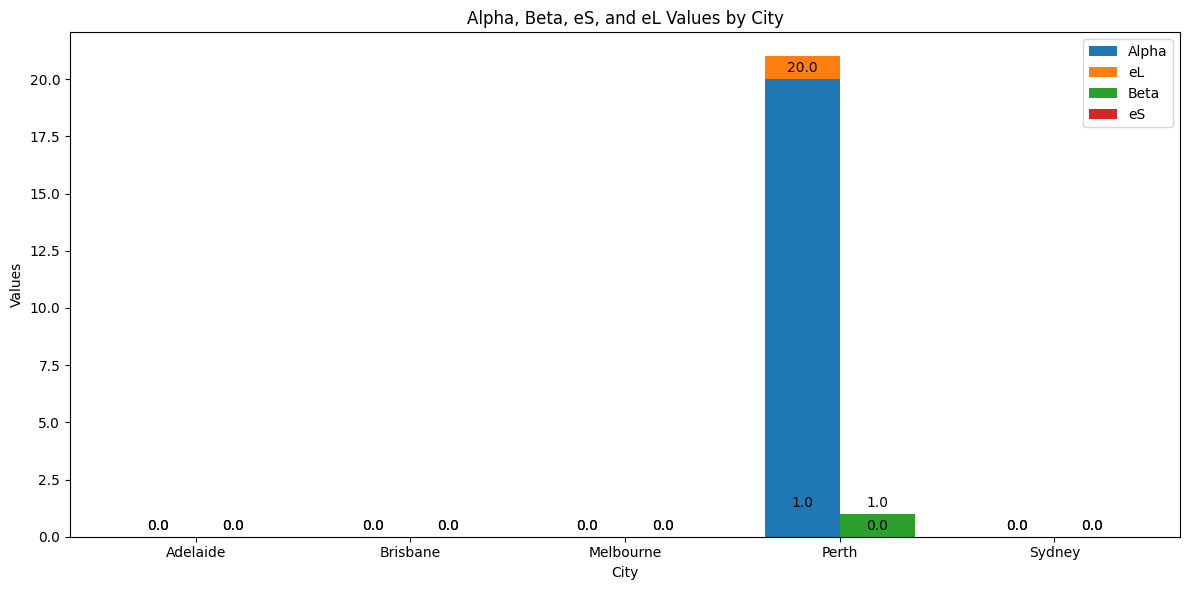

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
alpha_vals = [alpha_values[city] for city in cities]
beta_vals = [beta_values[city] for city in cities]
eS_vals = [eS_values[city] for city in cities]
eL_vals = [eL_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Stacked bars for alpha and eL
rects1 = ax.bar(x, alpha_vals, width, label='Alpha')
rects2 = ax.bar(x, eL_vals, width, bottom=alpha_vals, label='eL')

# Separate bars for beta and eS
rects3 = ax.bar(x + width, beta_vals, width, label='Beta')
rects4 = ax.bar(x + width, eS_vals, width, bottom=beta_vals, label='eS')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Values')
ax.set_title('Alpha, Beta, eS, and eL Values by City')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

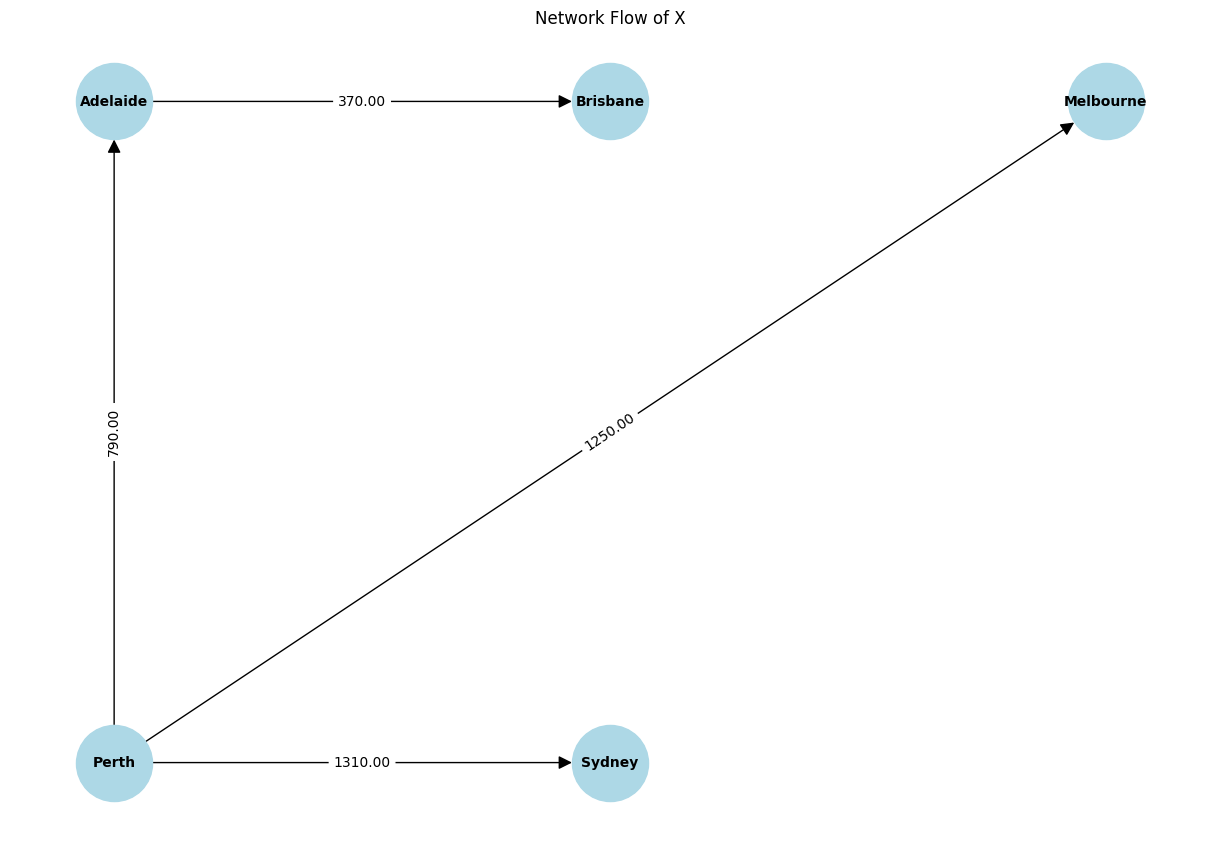

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges with flow values as labels
for i in cities:
    for j in cities:
        if i != j and X_values[i][j] > 0:  # Only add edges with positive flow
            G.add_edge(i, j, weight=X_values[i][j])

# Define custom positions for the nodes to equally space them
pos = {
    'Adelaide': (0, 1),
    'Brisbane': (1, 1),
    'Melbourne': (2, 1),
    'Perth': (0, 0),
    'Sydney': (1, 0)
}

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)

# Draw edge labels
edge_labels = {(i, j): f'{X_values[i][j]:.2f}' for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Network Flow of X")
plt.show()